In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
# from tensorflow.keras.layers import Dropout, Flatten, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
# from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

In [3]:
# Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
#import multiprocessing
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
DROPOUT_RATE = 0.1
EPOCHS = 50
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
# NFOLDS = 5 # No of folds for cross validation
WORKERS = 16 #multiprocessing.cpu_count()-1 #32 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

In [11]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [12]:
print(TRAIN_CSV_PATH)

dataset/train_label.csv


In [13]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# print(df_train.head())
# print()
# print(df_test.head())

In [14]:
X_train_files = np.array(df_train['image_name'].tolist()) # filenames
X_train_files.reshape((X_train_files.shape[0], 1))
y_train = np.array(df_train['tags'].tolist()) # image tags (ground truth)

<ipython-input-14-6b6633285bcc>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_train = np.array(df_train['tags'].tolist()) # image tags (ground truth)


In [15]:
# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


In [9]:
# plt.figure(figsize=(20, 20))
# res = [32, 64, 128, 256]
# NIMGS = 5
# train = df_train.reset_index()
# test = df_test.reset_index()

# for i in range(len(res)):
#     for j in range(NIMGS):
#         img = cv2.imread(os.path.join(TRAIN_PATH, df_train['image_name'][j+1]))
#         img = cv2.resize(img, (res[i], res[i]))
#         plt.subplot(len(res), NIMGS, i*NIMGS+j+1)
#         plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#         plt.title(df_train['tags'][j+1] + "\n" + str(res[i]) + "x" + str(res[i]))
#         plt.axis('off')
    
# plt.show()

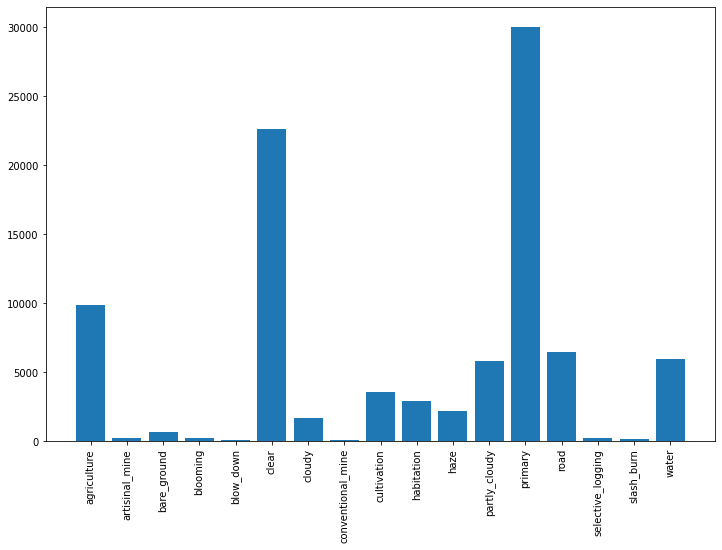

In [16]:
# Distribution of the labels

plt.figure(figsize=(12, 8))
            
plt.bar(range(len(tags_count)), list(tags_count), align='center')
plt.xticks(range(len(tags_count)), list(labels), rotation=90)

plt.show()

In [17]:
# Define learning curve and evaluation metric (f-2 Beta score):

def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

# F-Beta Score
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result

In [18]:
#Define CNN model architecture:

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.1),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.1),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.1),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        #Dropout(0.1),

        Flatten(),

#         Dense(1024, activation='relu'),
        Dense(17, activation='sigmoid') 
    ])

    #optimizer = Adam(0.001, decay=0.0001)

    return model

model = create_model()

clear_session()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       7

In [19]:
# Run the model

X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files, y_train, test_size=0.2, random_state=0)

train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

train_df['tags'] = train_df['tags']
val_df['tags'] = val_df['tags']

train_datagen = ImageDataGenerator(
    rescale=1./255#,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)
#print("train gen complete")
val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=TRAIN_PATH,
    x_col='image_name',
    y_col='tags',
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    directory=TEST_PATH,
    x_col='image_name',
    y_col='tags',
    #validate_filenames=False,
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    classes=labels,
    shuffle=False,
)

model_path = 'CNN_weights' + '.h5'

# clear_session()
# model = create_model()

adam = Adam(learning_rate=LR)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

print('here', history.history.keys())

# DO NOT KNOW WHAT THIS IS FOR?
# for key, value in history.history.items():
#     fold[num_fold][key] = value 

model.load_weights(model_path)

y_test = model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.
Epoch 1/50
203/203 [==============================] - 42s 176ms/step - loss: 0.3766 - fbeta_score_K: 0.4845 - val_loss: 0.2347 - val_fbeta_score_K: 0.5785
Epoch 2/50
203/203 [==============================] - 35s 168ms/step - loss: 0.2249 - fbeta_score_K: 0.5955 - val_loss: 0.2183 - val_fbeta_score_K: 0.5952
Epoch 3/50
203/203 [==============================] - 33s 157ms/step - loss: 0.2156 - fbeta_score_K: 0.6135 - val_loss: 0.2161 - val_fbeta_score_K: 0.6310
Epoch 4/50
203/203 [==============================] - 34s 164ms/step - loss: 0.2094 - fbeta_score_K: 0.6285 - val_loss: 0.2086 - val_fbeta_score_K: 0.6260
Epoch 5/50
203/203 [==============================] - 35s 167ms/step - loss: 0.1987 - fbeta_score_K: 0.6485 - val_loss: 0.1841 - val_fbeta_score_K: 0.6887
Epoch 6/50
203/203 [==================

In [20]:
import pandas as pd

train_history = pd.DataFrame(history.history)
train_history

,loss,fbeta_score_K,val_loss,val_fbeta_score_K,lr
0,0.289883,0.534694,0.234686,0.578532,0.0001
1,0.222715,0.600251,0.218296,0.595192,0.0001
2,0.215276,0.616073,0.216147,0.631023,0.0001
3,0.207013,0.633489,0.208605,0.626040,0.0001
4,0.195649,0.655096,0.184143,0.688712,0.0001
5,0.182208,0.680825,0.178350,0.687559,0.0001
6,0.175147,0.694491,0.165431,0.708511,0.0001
7,0.166713,0.709784,0.161572,0.711041,0.0001
8,0.161174,0.720461,0.163529,0.709511,0.0001
9,0.153613,0.734011,0.146973,0.746923,0.0001


In [21]:
train_history.to_csv('CNN_Baseline_train_history.csv', sep=',')

In [22]:
# loss = np.zeros(EPOCHS,dtype=float)
# val_loss = np.zeros(EPOCHS,dtype=float)
# fbeta_score_K = np.zeros(EPOCHS,dtype=float)
# val_fbeta_score_K = np.zeros(EPOCHS,dtype=float)

# for key,val in fold.items():
#     loss += np.array(fold[key]['loss'])
#     val_loss += np.array(fold[key]['val_loss'])
#     fbeta_score_K += np.array(fold[key]['fbeta_score_K'])
#     val_fbeta_score_K += np.array(fold[key]['val_fbeta_score_K'])
# print(loss)
# print(val_loss)
# print(fbeta_score_K)
# print(val_fbeta_score_K)

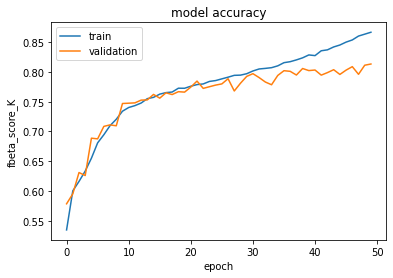

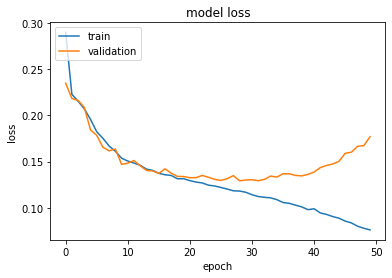

In [25]:
plt.plot(train_history['fbeta_score_K'])
plt.plot(train_history['val_fbeta_score_K'])
plt.title('model accuracy')
plt.ylabel('fbeta_score_K')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(train_history['loss'])
plt.plot(train_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# #    "Accuracy"
# plt.plot(fold[0]['fbeta_score_K'])
# plt.plot(fold[0]['val_fbeta_score_K'])
# plt.title('model accuracy')
# plt.ylabel('fbeta_score_K')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()
# #   "Loss"
# plt.plot(fold[0]['loss'])
# plt.plot(fold[0]['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [ ]:
# Average the k results obtained from k-fold cross validation

result = np.array(y_test[0])
for i in range(1, NFOLDS):
    result += np.array(y_test[i])
result /= NFOLDS
result = pd.DataFrame(result, columns = labels)
result.head()

In [ ]:
#Pickling the result_new df
import pickle
FilePath = ROOT_PATH + '/' + 'result_mb_25.pickle'
pickle1_out = open(FilePath, 'wb')
pickle.dump(result, pickle1_out, protocol=4)
pickle1_out.close()

In [ ]:
#result.drop(['tags','image_name'],axis=1,inplace=True)
result.iloc[[0]]

In [ ]:
# Create label prediction and kaggle submission file 

preds = []
for i in range(result.shape[0]):
    a = result.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
#preds
#df_test['pred_tags'] = preds
#df_pred['image_name'] = df_test['image_name'].astype(str).str.slice(stop=-4)
#df_test.to_csv('submit.csv', index=False)

In [ ]:
df_test['pred_tags'] = preds
df_test.head(5)

In [ ]:
import pickle
pickle_result = open('/mnt/fast0/pp837/result_mb_25.pickle', 'rb')
result_mNet = pickle.load(pickle_result)

In [ ]:
preds = []
for i in range(result_mNet.shape[0]):
    a = result_mNet.iloc[[i]]
    a = a.apply(lambda x: x > THRES, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [ ]:
#df_train = pd.read_csv(TRAIN_CSV_PATH)
import pandas as pd
df_test = pd.read_csv(TEST_CSV_PATH)

#df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

# print(df_train.head())
# print()
#print(df_test.head())
df_test['pred_tags'] = preds
df_test.head(5)

In [ ]:
from sklearn.metrics import fbeta_score

def calc_acc(df_test):
    test = df_test['tags']
    pred = df_test['pred_tags'].apply(lambda x: x.split(' '))
    
    from sklearn.preprocessing import MultiLabelBinarizer
    
    mlb = MultiLabelBinarizer()
    test = mlb.fit_transform(test)
    pred = mlb.transform(pred)
    score = fbeta_score(test,pred,beta=2,average='weighted')
    return score

acc_score = calc_acc(df_test)
print("Accuracy Score: ", acc_score)